In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

import targeted_functions as fns

import glob
import scipy.stats as ss

Do not have mpi4py package.


In [2]:
datadir='/Users/caitlinawitt/Desktop/nano11'
p11 = np.loadtxt(datadir+'/psrlist_Tg3yr.txt', dtype='S42').astype('str')


In [3]:
noisefiles = sorted(glob.glob(datadir + '/noisefiles_new/*noise.txt'))
noisefiles = [x for x in noisefiles if x.split('/')[-1].split('_')[0] in p11]

setpars = {}
for nfile in noisefiles:
    setpars.update(fns.get_noise_from_pal2(nfile))

In [4]:
amp=[]
gamma=[]
for psr in p11:
    amp.append(10**setpars[psr+'_red_noise_log10_A'])
    gamma.append(setpars[psr+'_red_noise_gamma'])
alpha=(np.array(gamma)-3)/(-2)
amp = np.array(amp)

In [5]:
#Iguchi params
m1=1.2e9
m2=7e8
M_c=(m1*m2)**(3./5)/(m1+m2)**(1./5)
z = 0.0213
DL = 85.8
f_0 =6.04*10**(-8)

skypos = SkyCoord('02h23m11.4112s', '+42d59m31.385s', frame='icrs')
h_0_Circ = hassky.h0_circ(M_c,DL,f_0)

In [6]:
T_obs_array = [11.5,14.5,20.]*u.yr#,25.,30.]*u.yr
N_pulsar = 33
sigma = 100*u.ns.to('s')*u.s # 100 ns
cadence = 23/u.yr #number of observations/yr
f_min = cadence.to('1/s')/2. #nyquist frequency

In [7]:
rmss=np.array([0.361 ,0.691 ,0.454 , 0.422, 0.178 ,1.07 ,0.323 ,0.672 , 0.23 ,0.199 ,0.426 ,3.31 ,0.108 ,0.52 ,0.128 ,0.842 ,
           3.59 ,0.239,0.809 ,3.65 ,0.148 ,0.544, 0.322 ,0.229,0.57 ,0.352 ,0.377 ,0.257 ,0.11 ,0.12 ,0.968 ,1.33 ,1.07 ,0.271])*1e-6

In [8]:
coord = []
c_1713 = []
c_0613 = []
for i in range(len(p11)):
    if 'J' in p11[i]:
        if '+' in p11[i]:
            #if '1713' not in p11[i]:
            a = p11[i].split('J')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+c[2:4]+'m00s')
            coord.append(SkyCoord(ra, dec, frame='icrs'))

        else:
            a = p11[i].split('J')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+c[2:4]+'m00s')            
            coord.append(SkyCoord(ra, dec, frame='icrs'))
    else:
        if '+' in p11[i]:
            a = p11[i].split('B')[1]
            b = a.split('+')[0]
            c = a.split('+')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('+'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
        else:
            a = p11[i].split('B')[1]
            b = a.split('-')[0]
            c = a.split('-')[1]
            ra = (b[0:2]+'h'+b[2:4]+'m00s')
            dec = ('-'+c[0:2]+'d'+'00m00s')
            coord.append(SkyCoord(ra, dec, frame='fk4'))
            


In [9]:
#Make a set of random sky positions
#phi = np.random.uniform(0, 2*np.pi,size=N_pulsar)
#cos_theta = np.random.uniform(-1,1,size=N_pulsar)
#theta = np.arccos(cos_theta)

phi = np.array([c.ra.radian for c in coord])
theta = np.array([np.pi/2 - c.dec.radian for c in coord])

#THIS IS WRONG?
#Adding 3c 66b sky position for plots.
theta_3c = np.array(np.pi/2-skypos.dec.radian)
phi_3c = np.array(skypos.ra.radian)

In [10]:
len(coord)

34

In [51]:
SkyAvg = False
SNR = []
for T_obs in T_obs_array:
    Tspan = T_obs.to('s') #Tspan in seconds
    #Simulate a set of identical pulsars, with different sky positions.
    freqs = np.logspace(np.log10(1/(5*Tspan.value)),np.log10(f_min.value),500)

    psrs = hassim.sim_pta(timespan=T_obs.value, cad=23, sigma=rmss,
                    phi=phi, theta=theta, A_rn = amp, alpha=alpha, freqs = freqs)
    spectra = []
    for p in psrs:
        sp = hassen.Spectrum(p, freqs=freqs)
        sp.NcalInv
        spectra.append(sp)
        
    if SkyAvg:
        #make deterministic pta
        pta = hassen.DeterSensitivityCurve(spectra)
        indx_f_0 = np.abs(pta.freqs-f_0).argmin()
        #Eqn 70 of Hazboun, et al.
        SNR.append((h_0_Circ.to('')*np.sqrt(Tspan/pta.S_eff[indx_f_0])).value)
    else:
        #For sensitivity at a particular sky location (ie at the 3c66b)
        #Use the healpy functions to get the sky coordinates
        NSIDE = 32
        NPIX = hp.nside2npix(NSIDE)
        IPIX = np.arange(NPIX)
        theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)
        theta_gw = np.append(theta_gw,theta_3c)
        phi_gw = np.append(phi_gw,phi_3c)
        
        sky_map = hassky.SkySensitivity(spectra,theta_gw, phi_gw)
        indx_f_0 = np.abs(sky_map.freqs-f_0).argmin()
        #SNR.append((h_0_Circ.to('')*np.sqrt(Tspan/sky_map.S_effSky[indx_f_0,-1])).value)
        hCirc = hassky.h_circ(M_c,DL,f_0,Tspan.value,sky_map.freqs).to('')

        SNR.append(sky_map.SNR(hCirc.value)[-1])
    print(T_obs,' done.')

AttributeError: 'float' object has no attribute 'to'

In [12]:
np.shape(SNR)

(5,)

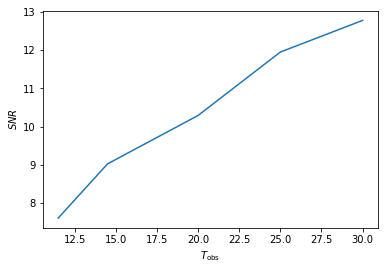

In [13]:
plt.figure()
plt.plot(T_obs_array.value,SNR)
plt.ylabel(r'$SNR$')
plt.xlabel(r'$T_{\mathrm{obs}}$')
plt.show()

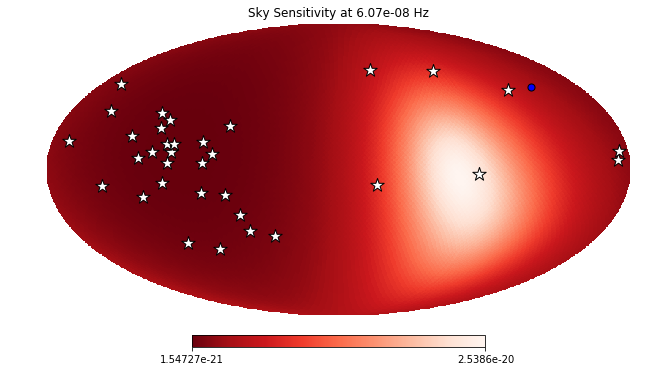

In [14]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
pixarr = hp.ang2pix(NSIDE,theta,phi)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)


hp.mollview(sky_map.S_effSky[indx_f_0,:-1],
            title="Sky Sensitivity at {0:2.2e} Hz".format(sky_map.freqs[indx_f_0]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200)
hp.visufunc.projscatter(theta_3c,phi_3c,marker='.',color='b',edgecolors='k',
                        s=200)
plt.show()

In [21]:
T_obs_array = [11,12.5,14., 20., 25.]*u.yr

N_11 = 34
N_12p5 = 45
N_9 = 18
N_per = (N_12p5-N_11)/1.5/u.yr
N = (N_11-N_9)/2/u.yr
N_p = np.mean([N_per.value, N.value])
N_psr = [int((N_11+N_per*t).value) for t in T_obs_array-T_obs_array[0]]

In [22]:
N_psr

[34, 45, 56, 100, 136]

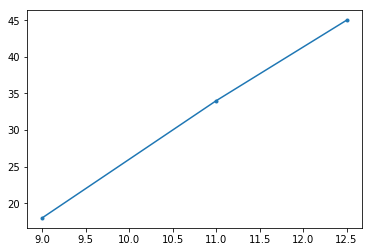

In [13]:
plt.plot([9,11,12.5], [N_9, N_11,N_12p5], marker = '.')

In [14]:
N_per

<Quantity 7.33333333 1 / yr>

In [15]:
theta_added = np.append(theta,0.)
theta_added2 = np.append(theta_added,np.pi)

phi_hist = np.histogram(phi, bins=np.linspace(0,2*np.pi,8))
theta_hist = np.histogram(theta_added2, bins=np.linspace(0,np.pi,8))
phi_dist = ss.rv_histogram(phi_hist)
theta_dist = ss.rv_histogram(theta_hist)


Text(0.5, 0, 'phi')

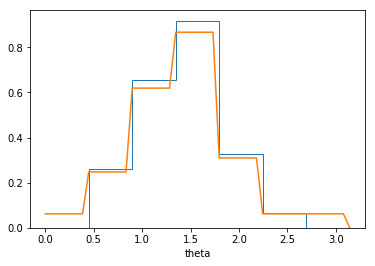

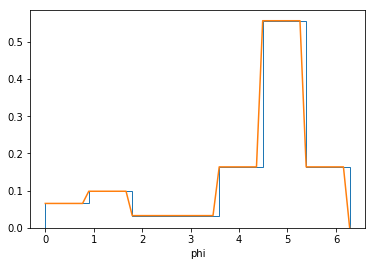

In [16]:
t = np.linspace(0,np.pi,50)
p = np.linspace(0,2*np.pi,50)
plt.hist(theta, histtype='step', density= True, bins = np.linspace(0,np.pi,8));
plt.plot(t,theta_dist.pdf(t));
plt.xlabel('theta')
plt.figure()
plt.hist(phi, histtype='step', density= True, bins=np.linspace(0,2*np.pi,8));
plt.plot(p,phi_dist.pdf(p));
plt.xlabel('phi')

In [59]:
N_psr

[34, 45, 56]

In [23]:
curves_psrs=[]
freqs_sm = []
added_theta = np.array([])
added_phi = np.array([])
added_amp = np.array([])
added_alpha = np.array([])
added_rmss = np.array([])

for i,T_obs in enumerate(T_obs_array):
    

    
    Tspan = T_obs.to('s') #Tspan in seconds
    #Simulate a set of identical pulsars, with different sky positions.
    freqs = np.logspace(np.log10(1/(5*Tspan.value)),np.log10(f_min.value),500)
    if T_obs == T_obs_array[0]:
        psrs3 = hassim.sim_pta(timespan=T_obs.value,cad=23,sigma=rmss*T_obs_array[0]/T_obs,
                         phi=phi,theta=theta,A_rn=amp,alpha=alpha,freqs=freqs)
    else:
        N_add = int(N_psr[i] -N_psr[i-1])
        '''
        tspan = np.ones(N_psr[0])*T_obs
        #N_add = int(N_psr[i] -N_psr[i-1])
        for i in range(int(N_add/N_per.value)-1,-1,-1):
            a = np.ones(int(N_per.value))*3*u.yr+i*u.yr
            tspan = np.append(tspan,a).value*u.yr
        print(tspan)
        '''
        #Tspan = tspan.to('s')
        new_ind_30 = np.random.choice(range(len(rmss)), size = N_add)
        new_rmss = rmss[new_ind_30]
        new_amps = amp[new_ind_30]
        new_alpha = alpha[new_ind_30]
        new_theta = theta_dist.rvs(size = N_add) 
        new_phi = phi_dist.rvs(size=N_add)
        
        added_theta = np.append(added_theta,new_theta)
        added_phi = np.append(added_phi,new_phi)
        added_amp = np.append(added_amp,new_amps)
        added_alpha= np.append(added_alpha,new_alpha)
        added_rmss = np.append(added_rmss,new_rmss)
        
        
        
        psrs3 = hassim.sim_pta(timespan=T_obs.value,cad=23,sigma=np.append(rmss,added_rmss)*T_obs_array[0]/T_obs,
                         phi=np.append(phi,added_phi),theta=np.append(theta,added_theta),
                               A_rn=np.append(amp,added_amp),
                               alpha=np.append(alpha,added_alpha),
                               freqs=freqs)

    spectra3 = []
    for p in psrs3:
        sp = hassen.Spectrum(p, freqs=freqs)
        sp.NcalInv
        spectra3.append(sp)

    pta=hassen.DeterSensitivityCurve(spectra3)
    #Use the healpy functions to get the sky coordinates
    NSIDE = 32
    NPIX = hp.nside2npix(NSIDE)
    IPIX = np.arange(NPIX)
    theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)
    theta_gw = np.append(theta_gw,theta_3c)
    phi_gw = np.append(phi_gw,phi_3c)

    sky_loc = 'PTA Sensitivity at '
    sky_loc += '{0:2.1f}$^\circ$N, {1:2.1f}$^\circ$E'.format(np.rad2deg(theta_gw[-1]),
                                                   np.rad2deg(phi_gw[-1]))
    indx_f_0_pta = np.abs(pta.freqs-f_0).argmin()
    sky_map3 = hassky.SkySensitivity(spectra3,theta_gw, phi_gw)
    indx_f_0_SM = np.abs(sky_map3.freqs-f_0).argmin()
    curves_psrs.append(sky_map3.h_c[:,-1])
    freqs_sm.append(sky_map3.freqs)

    print(T_obs)

11.0 yr
12.5 yr
14.0 yr
20.0 yr
25.0 yr


In [21]:
for i,T_obs in enumerate(T_obs_array):
    if T_obs == T_obs_array[0]:
        tspan = T_obs
    else:
    
        N_add = int(N_psr[i] -N_psr[i-1])
        
        tspan = np.ones(N_psr[0])*T_obs
        #N_add = int(N_psr[i] -N_psr[i-1])
        for i in range(int(N_add/N_per.value)-1,-1,-1):
            a = np.ones(int(N_per.value))*3*u.yr+i*u.yr
            tspan = np.append(tspan,a).value*u.yr
    print(tspan)

11.5 yr
[14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5
 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5 14.5
 14.5 14.5 14.5 14.5 14.5 14.5  5.   5.   5.   5.   4.   4.   4.   4.
  3.   3.   3.   3. ] yr
[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.  7.  7.
  7.  7.  6.  6.  6.  6.  5.  5.  5.  5.  4.  4.  4.  4.  3.  3.  3.  3.] yr
[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.  7.  7.
  7.  7.  6.  6.  6.  6.  5.  5.  5.  5.  4.  4.  4.  4.  3.  3.  3.  3.] yr


In [ ]:
N_add = 12
T_obs = 14.5*u.yr
tspan = np.ones(N_psr[0])*T_obs_array[1]
print(tspan)
#N_add = int(N_psr[i] -N_psr[i-1])
for i in range(int(N_add/N_per.value)-1,-1,-1):
    print(i)
    a = np.ones(int(N_per.value))*3*u.yr+i*u.yr
    print(a)
    tspan = np.append(tspan,a).value*u.yr

In [ ]:
tspan

In [19]:
h=8* (np.pi)**(2./3) * (const.G*(u.M_sun)/(const.c**3))**(5./3) * (u.Hz)**(2./3) \
            * (10)**(-1./2)*const.c /(DL*u.Mpc)

h_iguchi = h * M_c**(5./3)*f_0**(2./3)
h_iguchi = h_iguchi.to(u.dimensionless_unscaled)

ValueError: Unrecognized marker style '--'

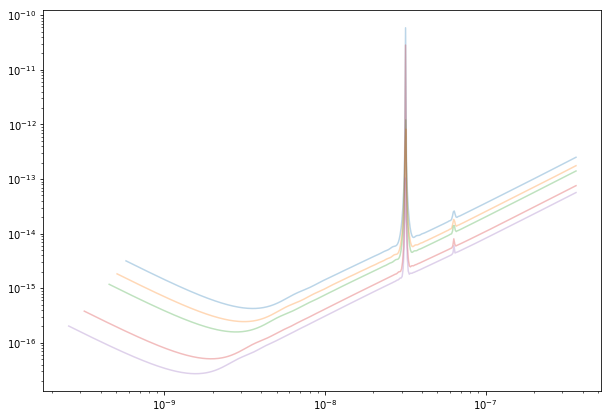

In [27]:
plt.figure(figsize=(10,7))

for i,T_obs in enumerate(T_obs_array):
    plt.loglog(freqs_sm[i], curves_psrs[i], label=T_obs, alpha = 0.3)
for i,T_obs in enumerate(T_obs_array):
    plt.loglog(freqs_sm[i], curves_psrs[i], label=T_obs, marker = '--')
plt.scatter(pta.freqs[indx_f_0_pta], h_iguchi, label='Iguchi', color='C0', marker='*', s=100)
plt.scatter(pta.freqs[indx_f_0_pta], 2.81e-14, marker = 'v', label='Witt_UL', color='C0', s=100)
plt.scatter(pta.freqs[indx_f_0_pta], 5e-14, marker = 'o', label='real_data_hasasia', color='C0')

plt.legend(loc='upper left')
plt.xlim(3e-8,1e-7)
plt.ylim(5e-15,8e-14)

In [ ]:
np.shape(freqs_sm)

In [ ]:
N_per

In [ ]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
pixarr = hp.ang2pix(NSIDE,theta,phi)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

hp.mollview(sky_map.S_effSky[indx_f_0_SM][:-1],
            title="Sky Sensitivity at {0:2.2e} Hz".format(sky_map.freqs[indx_f_0_SM]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map3.thetas,sky_map3.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200)
hp.visufunc.projscatter(added_theta,added_phi,
                        marker='*',color='C0',
                        edgecolors='k',s=200)
hp.visufunc.projscatter(theta_3c,phi_3c,marker='.',color='b',edgecolors='k',
                        s=200)
plt.show()

In [22]:

PsrList_Full = ['B1855+09','B1937+21','B1953+29','J0023+0923','J0030+0451',\
                'J0340+4130','J0613-0200','J0636+5128','J0645+5158','J0740+6620',\
                'J0931-1902','J1012+5307','J1024-0719','J1125+7819','J1453+1902',\
                'J1455-3330','J1600-3053','J1614-2230','J1640+2224','J1643-1224',\
                'J1713+0747','J1738+0333','J1741+1351','J1744-1134','J1747-4036',\
                'J1832-0836','J1853+1303','J1903+0327','J1909-3744','J1910+1256',\
                'J1911+1347','J1918-0642','J1923+2515','J1944+0907','J2010-1323',\
                'J2017+0603','J2033+1734','J2043+1711','J2145-0750','J2214+3000',\
                'J2229+2643','J2234+0611','J2234+0944','J2302+4442','J2317+1439']

In [23]:
len(PsrList_Full)

45